<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/FINANCE/Factor_Loadings_vs_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Factor Loadings and Benchmark Comparison

This notebook is constructed to quantify and visualize the factor exposures of selected Dimensional Fund Advisors (DFA) ETFs relative to broad-market investable index-funds benchmarks.  
We use monthly total-return data from Yahoo Finance and the Fama–French factor datasets hosted in our public GitHub repository.

**Note:** Although the core analysis was handwritten, LLM coding agents were used to make the code more robust and better documented.

From the data, Fama-French 5-Factor + Momentum betas for each fund are estimated to get a sense of the fund's exposure to:
- Market (`MKT_RF`)
- Size (`SMB`)
- Value (`HML`)
- Profitability (`RMW`)
- Investment (`CMA`)
- Momentum (`Mom`)

Cumulative performance of the fund is then plotted against the most relevant benchmark. VTI (U.S. total market) for US funds, or VXUS (ex-U.S. total market) for funds in international equity. The plots go as far back as the data go. For the ETFs where the predecessor mutual funds are known, the mutual fund data are used to extend the data period back further.

---

### Data Sources

All factor data are drawn from the **Ken French Data Library**, curated and harmonized through our repository:

| Dataset | Source | Coverage | Universe |
|----------|---------|-----------|-----------|
| `us_ff5_mom` | Fama–French U.S. 5-Factor + Momentum | 1963–present | U.S. Market |
| `global_exus_ff5_mom` | Fama–French Developed ex-U.S. 5-Factor + Momentum | 1990–present | Developed ex-U.S. Markets |

A copy of these datasets are kept in the [`FamaFrench`](https://github.com/haribharadwaj/FamaFrench) repository, refreshed monthly via GitHub Actions to ensure data continuity. All series are monthly, in percent units, and indexed to month-end to align with typical fund reporting frequency.


---

### Notes

All analyses use open data and reproducible code.  
Factor datasets and scripts are provided under the [MIT License](https://opensource.org/licenses/MIT).  
Original Fama–French factors remain copyright of Kenneth R. French and must be cited as per the [Data Library Terms of Use](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).

---

### References

Fama, Eugene F., and Kenneth R. French. 1993. “Common Risk Factors in the Returns on Stocks and Bonds.” *Journal of Financial Economics* 33 (1): 3-56.  
Fama, Eugene F., and Kenneth R. French. 2015. “A Five-Factor Asset Pricing Model.” *Journal of Financial Economics* 116 (1): 1-22.  
Carhart, Mark M. 1997. “On Persistence in Mutual Fund Performance.” *Journal of Finance* 52 (1): 57-82.   
Fama, Eugene F., and Kenneth R. French. 2020. “The Value Premium.” *Journal of Finance* 75 (5): 2739-2779.


# Factor Tables and Helper Function Definitions
We load Fama–French factor tables directly from a GitHub repository. We estimate factor loadings, summarize alphas and R², and compare growth of capital for the fund versus an appropriate benchmark.

## Configuration

Set `TICKER` to the target fund. The benchmark will be detected automatically by comparing correlations with VTI and VXUS. No additional configuration is required.

In [1]:
# === Configuration ===
# Example ETF values: "DFAC", "DFAX", "DFAI", "DFAU", "DFAE", "DFSV", "AVUV"
TICKER = "DFAC"

## Helper Functions

This section defines helpers for data acquisition, factor loading estimation, expense ratio retrieval, and plotting.

In [2]:
import pandas as pd, numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings, io, requests

warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.display.float_format = '{:.4f}'.format

GITHUB_USER   = "haribharadwaj"
GITHUB_REPO   = "FamaFrench"
GITHUB_BRANCH = "main"

def _raw_url(path: str) -> str:
    return f"https://raw.githubusercontent.com/{GITHUB_USER}/{GITHUB_REPO}/{GITHUB_BRANCH}/{path}"

def load_repo_factors(dataset: str, prefer="parquet") -> pd.DataFrame:
    """
    Load factor tables hosted in the repo.
    dataset ∈ {"us_ff5_mom", "global_exus_ff5_mom"}.
    Returns monthly DataFrame in percent units; index coerced to month-end.
    """
    if prefer == "parquet":
        url = _raw_url(f"data/{dataset}.parquet")
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        df = pd.read_parquet(io.BytesIO(r.content))
    else:
        url = _raw_url(f"data/{dataset}.csv.gz")
        df = pd.read_csv(url, index_col=0, parse_dates=True)
    cols = ["MKT_RF","SMB","HML","RMW","CMA","Mom","RF"]
    for c in cols:
        if c not in df.columns:
            df[c] = pd.NA
    df = df[cols]
    df.index = pd.to_datetime(df.index).to_period("M").to_timestamp("M")
    return df.sort_index()

# --- Date/index utilities ---
def as_month_end(series: pd.Series) -> pd.Series:
    """Return a copy with a strict month-end DatetimeIndex and no duplicate months."""
    s = series.copy()
    s.index = pd.to_datetime(s.index).to_period("M").to_timestamp("M")
    s = s[~s.index.duplicated(keep="last")]
    s.name = series.name
    return s

def fmt_date(x):
    try:
        return pd.to_datetime(x).strftime("%Y-%m-%d")
    except Exception:
        return str(x)

# --- Yahoo Finance monthly total returns (Series) ---
def fetch_yahoo_monthly_series(ticker: str, start="2000-01-01") -> pd.Series:
    """Monthly total returns from Yahoo (Adjusted Close, month-end). Returns decimal returns."""
    df = yf.download(ticker, start=start, auto_adjust=True, progress=False)
    if df.empty:
        raise ValueError(f"No data for {ticker}.")
    px = df["Close"].resample("ME").last()
    rets = px.pct_change().dropna()
    rets.name = ticker.upper()
    return as_month_end(rets)

# --- Dimensional ETF → mutual-fund predecessor map (extendable) ---
DIMENSIONAL_PREDECESSOR_MAP = {
    # Core / Core 2
    "DFAC": "DFQTX",   # U.S. Core Equity 2
    "DFAX": "DFWIX",   # World ex-US Core Equity
    "DFAE": "DFCEX",   # Emerging Markets Core Equity
    "DFAI": "DFIEX",   # International Core Equity
    "DFAU": "DFEOX",   # U.S. Core Equity

    # Value / Vector
    "DFAT": "DFFVX",   # U.S. Targeted Value
    "DFUV": "DFVEX",   # U.S. Vector Equity
    "DFLV": "DFLVX",   # U.S. Large Cap Value
    "DFIV": "DFIVX",   # International Value
    "DFEV": "DFEVX",   # Emerging Markets Value

    # Small / Small Value
    "DFAS": "DFSTX",   # U.S. Small Cap
    "DFSV": "DFSVX",   # U.S. Small Cap Value
    "DFIS": "DFISX",   # International Small Company
}

def fetch_dimensional_combined(ticker: str, start="1990-01-01") -> pd.Series:
    """
    Single Series for `ticker` built by coalescing ETF with its mutual-fund predecessor.
    ETF values take precedence on overlap. Returns decimal monthly returns.
    """
    t = ticker.upper()

    def _s(tkr: str) -> pd.Series:
        s = fetch_yahoo_monthly_series(tkr, start=start)  # decimal returns
        s.name = tkr.upper()
        return as_month_end(s)

    etf = _s(t)
    mf_tkr = DIMENSIONAL_PREDECESSOR_MAP.get(t)
    if not mf_tkr:
        etf.name = t
        return etf

    try:
        mf = _s(mf_tkr)
    except Exception as e:
        print(f"[WARN] Predecessor {mf_tkr} fetch failed; ETF-only. Reason: {e}")
        etf.name = t
        return etf

    # Two-column frame (no Series.rename); coalesce ETF over MF
    both = pd.concat([mf, etf], axis=1).sort_index()
    both.columns = ["MF", "ETF"]
    combined = both["ETF"].fillna(both["MF"])
    combined = combined[~combined.index.duplicated(keep="last")]
    combined.name = t
    return combined

# --- Benchmark selection (VTI vs VXUS by correlation) ---
def choose_benchmark(fund_series: pd.Series):
    """Return ('VTI' or 'VXUS', correlation) after normalizing month-end indices."""
    f = as_month_end(fund_series)
    vti = fetch_yahoo_monthly_series("VTI")
    vxus = fetch_yahoo_monthly_series("VXUS")
    a = pd.concat([f, vti], axis=1).dropna()
    b = pd.concat([f, vxus], axis=1).dropna()
    corr_vti = a.corr().iloc[0,1] if a.shape[0] > 1 else -999
    corr_vxus = b.corr().iloc[0,1] if b.shape[0] > 1 else -999
    return ("VTI", corr_vti) if corr_vti >= corr_vxus else ("VXUS", corr_vxus)

def get_ff_us_5_plus_mom() -> pd.DataFrame:
    """U.S. Fama–French 5 factors + Momentum (from repo)."""
    return load_repo_factors("us_ff5_mom")

def get_ff_global_exus_5_plus_mom() -> pd.DataFrame:
    """
    Load Global (Developed ex-US) Fama–French 5 factors + Momentum
    from the GitHub repo in monthly percent units.
    """
    try:
        factors = load_repo_factors("global_exus_ff5_mom", prefer="parquet")
        print(f"Loaded global_exus_ff5_mom from repo: {factors.index.min().date()} → {factors.index.max().date()}  (n={len(factors)})")
    except Exception as e:
        raise RuntimeError(f"Failed to load global_exus_ff5_mom from GitHub repo: {e}")

    # Harmonize column names and ensure order
    rename_map = {"Mkt-RF":"MKT_RF", "MKT-RF":"MKT_RF", "Mom   ":"Mom", "Mom ":"Mom"}
    factors = factors.rename(columns=rename_map)
    expected = ["MKT_RF","SMB","HML","RMW","CMA","Mom","RF"]
    for c in expected:
        if c not in factors.columns:
            factors[c] = np.nan
    factors = factors[expected]

    # Clean index to month-end
    factors.index = factors.index.to_period("M").to_timestamp("M")

    # Show diagnostic info
    print({
        "mom_present": "Mom" in factors.columns,
        "mom_non_na": factors["Mom"].notna().sum(),
        "coverage": (factors.index.min(), factors.index.max()),
    })
    return factors

# --- Regression utilities ---
def annualize_alpha(monthly_alpha: float) -> float:
    """Convert monthly alpha (decimal) to annualized (decimal)."""
    return (1.0 + monthly_alpha)**12 - 1.0

def run_factor_regression(
    y_fund: pd.Series,
    X_factors: pd.DataFrame,
    rf_col: str = "RF",
    data_for_rf: pd.DataFrame | None = None,
    min_obs: int = 24,
):
    """
    Regress monthly fund excess returns on FF5 + Momentum factors.
    Returns: (table_df, meta_dict, model)
    """
    # ---- Coerce numeric and harmonize scale ----
    y = pd.to_numeric(y_fund, errors="coerce").astype("float64")
    X = X_factors.copy().apply(pd.to_numeric, errors="coerce")

    # If factors look like percents, convert to decimals
    if X.abs().stack().max() > 5:
        X /= 100.0

    # Keep only known columns in canonical order if present
    wanted = ["MKT_RF","SMB","HML","RMW","CMA","Mom"]
    X = X[[c for c in wanted if c in X.columns]]

    # ---- Align with RF and compute excess returns ----
    if (data_for_rf is not None) and (rf_col in data_for_rf.columns):
        rf = pd.to_numeric(data_for_rf[rf_col], errors="coerce").astype("float64")
        if rf.abs().max() > 5:
            rf /= 100.0
        idx = y.index.intersection(X.index).intersection(rf.index)
        y_excess = y.reindex(idx) - rf.reindex(idx)
        X = X.reindex(idx)
    else:
        idx = y.index.intersection(X.index)
        y_excess = y.reindex(idx)
        X = X.reindex(idx)

    # ---- Column pruning: drop factors with too few valid observations ----
    valid_counts = X.notna().sum(axis=0)
    keep_cols = [c for c in X.columns if valid_counts.get(c, 0) >= min_obs]
    X = X[keep_cols]
    if X.shape[1] == 0:
        raise ValueError("No factor columns have enough valid observations after alignment.")

    # ---- Drop any remaining NaNs across y and kept factors ----
    reg = pd.concat([y_excess.rename("y"), X], axis=1).dropna(how="any")
    y_excess = reg["y"]; X = reg.drop(columns="y")

    # ---- Basic identifiability check ----
    k = X.shape[1]
    if len(reg) < max(min_obs, k + 3):
        raise ValueError(
            f"Insufficient data after alignment for regression. "
            f"Rows={len(reg)}, factors={k}, required≥{max(min_obs, k+3)}."
        )

    # ---- Regression with intercept (alpha) ----
    Xc = sm.add_constant(X)
    model = sm.OLS(y_excess, Xc).fit()

    # ---- Results table ----
    rows = [{"Factor":"Alpha (monthly)", "Beta":model.params.get("const", np.nan),
             "t-stat":model.tvalues.get("const", np.nan), "p-value":model.pvalues.get("const", np.nan)}]
    for c in X.columns:
        rows.append({"Factor":c, "Beta":model.params.get(c, np.nan),
                     "t-stat":model.tvalues.get(c, np.nan), "p-value":model.pvalues.get(c, np.nan)})
    table_df = pd.DataFrame(rows).set_index("Factor")

    # ---- Meta ----
    alpha_m = float(model.params.get("const", np.nan))
    alpha_ann = (1 + alpha_m) ** 12 - 1 if np.isfinite(alpha_m) else np.nan
    meta = {
        "R^2": float(model.rsquared),
        "N": int(model.nobs),
        "Alpha (monthly)": alpha_m,
        "Alpha (annualized)": alpha_ann,
        "Start": str(y_excess.index.min().date()) if len(y_excess) else None,
        "End": str(y_excess.index.max().date()) if len(y_excess) else None,
        "Factors used": list(X.columns),
    }
    return table_df, meta, model

# --- CAGR from decimal monthly returns ---
def compute_cagr(rets: pd.Series) -> float:
    if len(rets) == 0:
        return np.nan
    growth = (1.0 + rets).prod()
    years = len(rets) / 12.0
    return growth**(1/years) - 1.0

# --- Expense ratios ---
ISSUER_ER_MAP = {
    "DFAC": 0.17, "DFAX": 0.29, "DFAE": 0.35, "DFAI": 0.18, "DFAU": 0.12,
    "VTI": 0.03, "VXUS": 0.07
}
def fetch_expense_ratio_issuer(ticker: str):
    """Issuer ER (%) for common funds; NaN if unknown."""
    return ISSUER_ER_MAP.get(ticker.upper(), np.nan)

def fetch_expense_ratio_yahoo(ticker: str):
    """Expense ratio from Yahoo. Returns percent if available, else NaN."""
    info = yf.Ticker(ticker).info
    for k in ["expenseRatio","annualReportExpenseRatio","netExpenseRatio",
              "feesExpensesInvestment","feesExpensesInvestmentAnnual"]:
        v = info.get(k, None)
        if v is not None:
            try:
                v = float(v)
                return v * 100.0 if v < 0.01 else v
            except Exception:
                continue
    return np.nan


## Data Acquisition and Model Choice

In [3]:
fund = TICKER.upper()

# Normalize all monthly series to strict month-end indices
fund_rets = as_month_end(fetch_dimensional_combined(fund))
bench_ticker, corr_val = choose_benchmark(fund_rets)
bench_rets = as_month_end(fetch_yahoo_monthly_series(bench_ticker))

# Diagnostics to confirm windows before intersection
print("Fund window:", fund_rets.index.min(), "→", fund_rets.index.max(), f"({len(fund_rets)} months)")
print("Benchmark window:", bench_rets.index.min(), "→", bench_rets.index.max(), f"({len(bench_rets)} months)")

# Explicit overlap
overlap = fund_rets.index.intersection(bench_rets.index)
if overlap.size == 0:
    raise ValueError("No overlapping monthly data between fund and benchmark after normalization.")

fund_rets_ov  = fund_rets.reindex(overlap)
bench_rets_ov = bench_rets.reindex(overlap)

common = pd.concat([fund_rets_ov, bench_rets_ov], axis=1).dropna()
if common.empty:
    print("Overlap months:", overlap.min(), "→", overlap.max(), f"({overlap.size} months)")
    print("Missing counts — fund:", fund_rets_ov.isna().sum(), "benchmark:", bench_rets_ov.isna().sum())
    raise ValueError("No overlapping monthly data between fund and benchmark.")

# Factor set selection with robust ex-US fallback
try:
    if bench_ticker == "VTI":
        factors = load_repo_factors("us_ff5_mom"); model_name = "US FF5 + Momentum (repo)"
        model_name = "US FF5 + Momentum"
    else:
        try:
            factors = load_repo_factors("global_exus_ff5_mom"); model_name = "Global ex-US FF5 + Momentum (repo)"
            model_name = "Global ex-US FF5 + Momentum"
        except Exception:
            factors = load_repo_factors("us_ff5_mom"); model_name = "US FF5 + Momentum (repo)"
            model_name = "US FF5 + Momentum (fallback for global factors)"
except Exception as e:
    raise RuntimeError(f"Factor dataset retrieval failed: {e}")

# Extra safety: enforce strict month-end on factor index (helpers already do this)
factors.index = pd.to_datetime(factors.index).to_period("M").to_timestamp("M")

# Join fund with factors on month-end index
reg_data = pd.concat([common[fund]], axis=1).join(factors, how='inner')
if reg_data.empty:
    print("Debug window (fund/bench):", common.index.min(), "→", common.index.max(), f"({len(common)} months)")
    print("Debug window (factors):", factors.index.min(), "→", factors.index.max(), f"({len(factors)} months)")
    raise ValueError("No overlapping period between fund returns and factor dataset.")

# ---- Units fix: FF factors are in percent; convert to decimals BEFORE regression ----
possible   = ['RF','MKT_RF','SMB','HML','RMW','CMA','UMD','Mom']
scale_cols = [c for c in possible if c in reg_data.columns]
if scale_cols:  # avoid “columns must be same length as key” on empty list
    reg_data.loc[:, scale_cols] = reg_data.loc[:, scale_cols] / 100.0

print("---- Diagnostics: index ranges at each stage ----")
print("Fund earliest:", fund_rets.index.min(), "latest:", fund_rets.index.max(), f"({len(fund_rets)} months)")
print("Benchmark earliest:", bench_rets.index.min(), "latest:", bench_rets.index.max(), f"({len(bench_rets)} months)")
print("Common earliest:", common.index.min(), "latest:", common.index.max(), f"({len(common)} months)")
print("Factors earliest:", factors.index.min(), "latest:", factors.index.max(), f"({len(factors)} months)")
print("reg_data earliest:", reg_data.index.min(), "latest:", reg_data.index.max(), f"({len(reg_data)} months)")

# Final selections for regression and downstream outputs
factor_cols   = [c for c in possible if c in reg_data.columns]
reg_factors   = reg_data[factor_cols]
aligned_fund  = reg_data[fund]
aligned_bench = common.loc[reg_data.index, bench_ticker]

print(f"Fund: {fund} | Benchmark: {bench_ticker} (corr={corr_val:.3f})")
print(f"Model: {model_name}")
print(f"Analysis window: {fmt_date(aligned_fund.index.min())} → {fmt_date(aligned_fund.index.max())}  (n={len(aligned_fund)} months)")

Fund window: 2005-10-31 00:00:00 → 2025-10-31 00:00:00 (241 months)
Benchmark window: 2001-07-31 00:00:00 → 2025-10-31 00:00:00 (292 months)
---- Diagnostics: index ranges at each stage ----
Fund earliest: 2005-10-31 00:00:00 latest: 2025-10-31 00:00:00 (241 months)
Benchmark earliest: 2001-07-31 00:00:00 latest: 2025-10-31 00:00:00 (292 months)
Common earliest: 2005-10-31 00:00:00 latest: 2025-10-31 00:00:00 (241 months)
Factors earliest: 1963-07-31 00:00:00 latest: 2025-07-31 00:00:00 (745 months)
reg_data earliest: 2005-10-31 00:00:00 latest: 2025-07-31 00:00:00 (238 months)
Fund: DFAC | Benchmark: VTI (corr=0.986)
Model: US FF5 + Momentum
Analysis window: 2005-10-31 → 2025-07-31  (n=238 months)


In [4]:
# Ensure growth-of-$1 plot spans the FULL fund–benchmark overlap
def _growth_of_1_on(idx, ser):
    s = ser.reindex(idx).dropna()
    return (1.0 + s).cumprod()

_idx_common = fund_rets.index.intersection(bench_rets.index)
g_fund  = _growth_of_1_on(_idx_common, fund_rets)
g_bench = _growth_of_1_on(_idx_common, bench_rets)


## Factor Loadings Table

In [5]:
# Run factor regressions on the same aligned factor window for fund and benchmark
# Assumes variables: aligned_fund, aligned_bench, reg_data, model_name, fund, bench_ticker, run_factor_regression

# Ensure factor matrix from reg_data (so RF is available inside the helper)
wanted = ["MKT_RF","SMB","HML","RMW","CMA","Mom"]
factor_cols = [c for c in wanted if c in reg_data.columns]
reg_factors = reg_data[factor_cols]

# Fund regression
table_fund, meta, model = run_factor_regression(
    aligned_fund, reg_factors, rf_col="RF", data_for_rf=reg_data
)

# Benchmark regression (same factors, same process)
table_bench, meta_bench, model_bench = run_factor_regression(
    aligned_bench, reg_factors, rf_col="RF", data_for_rf=reg_data
)

# Combine betas: fund + benchmark
combined = table_fund.copy()
if "Beta" in combined.columns:
    combined.rename(columns={"Beta": "Beta (fund)"}, inplace=True)

if "Beta" in table_bench.columns:
    combined = combined.join(
        table_bench[["Beta"]].rename(columns={"Beta": "Beta (benchmark)"}),
        how="outer"
    )

# Optional: enforce a consistent, readable row order (alpha first, then factors)
row_order = ["Alpha (monthly)"] + [c for c in wanted if c in combined.index]
combined = combined.reindex(row_order).dropna(how="all")

# --- Formatting for display (preserve your original style) ---
table_fmt = combined.copy()
for col in [c for c in table_fmt.columns if "Beta" in c]:
    table_fmt[col] = table_fmt[col].map(lambda x: f"{x:.4f}" if pd.notna(x) else "—")
for col in ["t-stat", "p-value"]:
    if col in table_fmt.columns:
        table_fmt[col] = table_fmt[col].map(
            (lambda x: f"{x:.2f}") if col == "t-stat" else (lambda x: f"{x:.3f}")
        )

meta_df = pd.DataFrame({
    "Metric": ["R^2", "N", "Alpha (monthly)", "Alpha (annualized)"],
    "Value": [
        f"{meta['R^2']:.4f}",
        f"{meta['N']}",
        f"{meta['Alpha (monthly)']:.4%}",
        f"{meta['Alpha (annualized)']:.4%}",
    ]
})

# Label the index explicitly for clarity
table_fmt.index.name = "Factor"

# Display
display(
    table_fmt.style
        .set_caption(f"{fund} — Factor Loadings ({model_name})")
)
display(
    meta_df.style.hide(axis='index')
        .set_caption("Regression Summary")
)

# ---- Quiet diagnostics  ----
diag = {
    "factors_available": list(reg_factors.columns),
    "mom_present": "Mom" in reg_factors.columns,
    "mom_non_na": int(reg_factors["Mom"].notna().sum()) if "Mom" in reg_factors.columns else 0,
    "analysis_window": (str(reg_data.index.min().date()), str(reg_data.index.max().date())),
    "model_factors_used": meta.get("Factors used", []),
}
# print(diag)  # uncomment if needed


,Beta (fund),t-stat,p-value,Beta (benchmark)
Factor,,,,
Alpha (monthly),-0.0007,-2.58,0.010,-0.0002
MKT_RF,1.0221,160.22,0.000,0.9999
SMB,0.1866,16.37,0.000,0.0002
HML,0.1342,12.16,0.000,0.0130
RMW,0.0606,4.13,0.000,0.0230
CMA,0.0329,1.94,0.053,0.0053
Mom,-0.0154,-2.33,0.021,-0.0026


Metric,Value
R^2,0.9939
N,238
Alpha (monthly),-0.0682%
Alpha (annualized),-0.8148%


## Net Annualized Return and Performance Plot

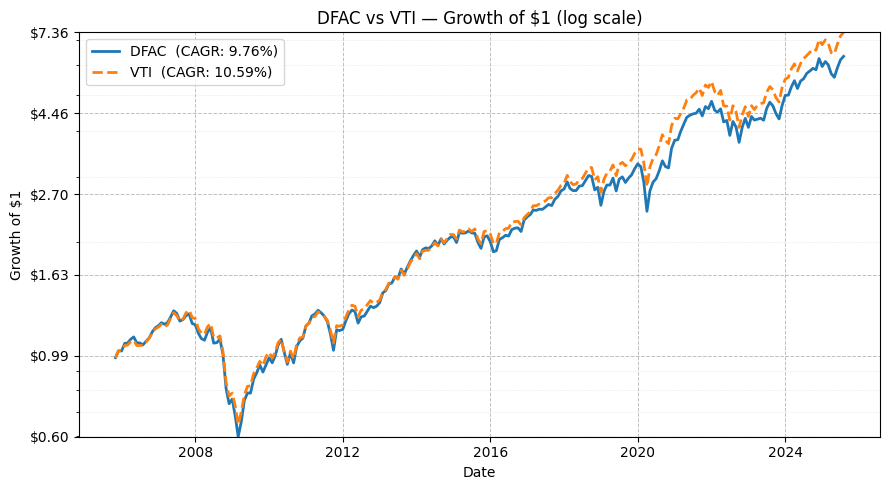

In [6]:
# --- Growth of $1 with log scale and clean ticks (no exponents anywhere) ---

cagr_fund  = compute_cagr(aligned_fund)
cagr_bench = compute_cagr(aligned_bench)

idx = (1 + aligned_fund).cumprod()
bdx = (1 + aligned_bench).cumprod()


label_fund  = f"{fund}  (CAGR: {cagr_fund:.2%})"
label_bench = f"{bench_ticker}  (CAGR: {cagr_bench:.2%})"

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(idx.index, idx.values, label=label_fund, linewidth=2)
ax.plot(bdx.index, bdx.values, label=label_bench, linewidth=2, linestyle="--")

# --- LOG SCALE + custom major ticks + silence minor ticks ---
from matplotlib.ticker import FixedLocator, NullFormatter

ax.set_yscale("log")

# Data-driven range and ~6 major ticks
ymin = max(min(idx.min(), bdx.min()), 1e-6)
ymax = max(idx.max(), bdx.max())
yticks = np.logspace(np.log10(ymin), np.log10(ymax), num=6)

# Use ONLY these as majors; hide minors completely
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.yaxis.set_minor_formatter(NullFormatter())      # no labels on minor ticks
ax.set_ylim(ymin, ymax)

# Pretty $ labels (no scientific offset, no 10^x)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"${y:,.2f}"))
ax.get_yaxis().get_offset_text().set_visible(False)

# Grid
ax.grid(True, which="major", linestyle="--", linewidth=0.7, alpha=0.8)
ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.4)

ax.set_title(f"{fund} vs {bench_ticker} — Growth of $1 (log scale)")
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1")
ax.legend(loc="best", frameon=True)

plt.tight_layout()
plt.show()


## Expense Ratio Comparison

In [7]:
issuer_er = fetch_expense_ratio_issuer(fund)
yahoo_er = fetch_expense_ratio_yahoo(fund)

er_tbl = pd.DataFrame({
    "Fund": [fund],
    "Issuer ER (%)": [issuer_er if not np.isnan(issuer_er) else "—"],
    "Yahoo ER (%)": [yahoo_er if not np.isnan(yahoo_er) else "—"]
})
display(er_tbl.style.hide(axis='index').set_caption("Expense Ratios (Issuer vs Yahoo)"))

issuer_er_b = fetch_expense_ratio_issuer(bench_ticker)
yahoo_er_b = fetch_expense_ratio_yahoo(bench_ticker)
er_b_tbl = pd.DataFrame({
    "Fund": [bench_ticker],
    "Issuer ER (%)": [issuer_er_b if not np.isnan(issuer_er_b) else "—"],
    "Yahoo ER (%)": [yahoo_er_b if not np.isnan(yahoo_er_b) else "—"]
})
display(er_b_tbl.style.hide(axis='index').set_caption("Benchmark Expense Ratios (Issuer vs Yahoo)"))

Fund,Issuer ER (%),Yahoo ER (%)
DFAC,0.170000,0.170000


Fund,Issuer ER (%),Yahoo ER (%)
VTI,0.030000,0.030000


## Interpretation and Closing Remarks

Factor regressions confirm that the DFA Core Equity ETFs exhibit systematic exposures to factors identified in the Fama-French framework.

# Correlations between factors

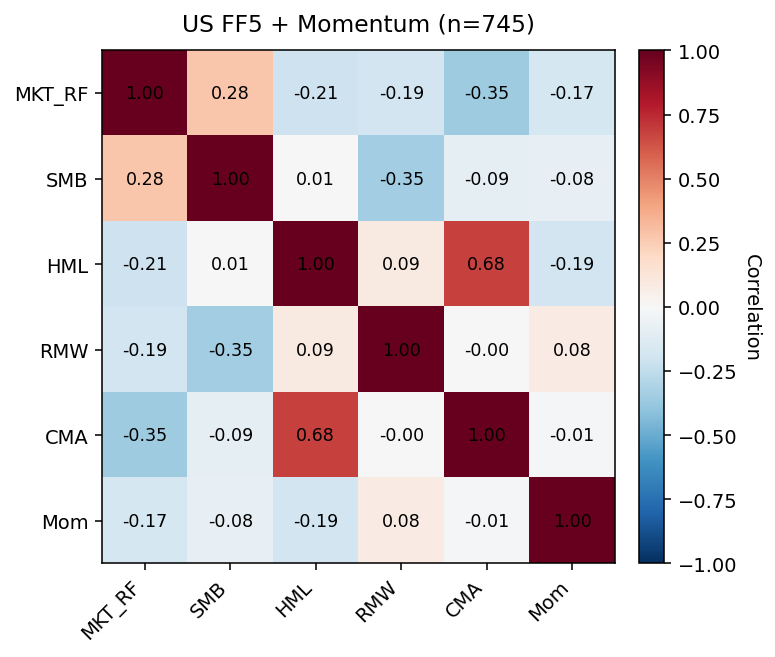

Loaded global_exus_ff5_mom from repo: 1990-07-31 → 2025-08-31  (n=422)
{'mom_present': True, 'mom_non_na': np.int64(418), 'coverage': (Timestamp('1990-07-31 00:00:00'), Timestamp('2025-08-31 00:00:00'))}


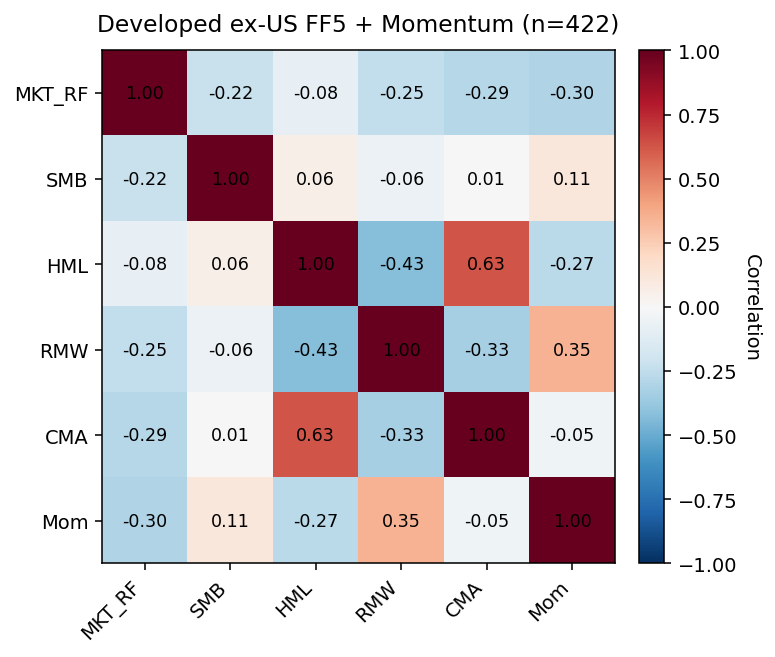

In [8]:
# --- Correlation heatmaps: US vs ex-US FF5 + Momentum ---

def _prep_for_corr(df, min_non_na=24):
    cols = ["MKT_RF","SMB","HML","RMW","CMA","Mom"]
    # keep only present columns and require some data
    df2 = df.reindex(columns=[c for c in cols if c in df.columns]).apply(pd.to_numeric, errors="coerce")
    good = [c for c in df2.columns if df2[c].notna().sum() >= min_non_na]
    return df2[good]

def _plot_corr(corr, title, cmap="RdBu_r"):
    import numpy as np
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(5.6, 4.8), dpi=140)
    im = ax.imshow(corr.values, cmap=cmap, vmin=-1, vmax=1)
    ax.set_xticks(range(corr.shape[1]), labels=corr.columns, rotation=45, ha="right")
    ax.set_yticks(range(corr.shape[0]), labels=corr.index)
    ax.set_title(title, pad=10)
    # annotate
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f"{corr.iat[i,j]:.2f}", ha="center", va="center", fontsize=9, color="black")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Correlation", rotation=270, labelpad=12)
    plt.tight_layout()
    plt.show()

# US factors
us_factors = get_ff_us_5_plus_mom()
us_df = _prep_for_corr(us_factors)
us_corr = us_df.corr(min_periods=12)
_plot_corr(us_corr, f"US FF5 + Momentum (n={len(us_df)})")

# ex-US (Developed ex-US) factors
ex_factors = get_ff_global_exus_5_plus_mom()
ex_df = _prep_for_corr(ex_factors)
ex_corr = ex_df.corr(min_periods=12)
_plot_corr(ex_corr, f"Developed ex-US FF5 + Momentum (n={len(ex_df)})")
